# Building an Educational Content Recommender System in PyTorch

## Introduction

Welcome to this PyTorch tutorial focused on creating a recommender system for educational content. The goal is to predict the most effective distribution of study time across various content types, enhancing student learning experiences. We'll utilize a dataset reflecting student interactions with different educational materials to train our model.

## Understanding the Dataset

Our dataset comprises various elements capturing student interactions with educational content. The dataset includes student identifiers, types of educational content, and interaction details, providing rich information for model training. Importantly, we'll use 'LearnerProfile' only for validation, not for training the model.

### Key Elements

- **StudentID**: Provides unique identification for personalized recommendations.
- **TopicID and ContentID**: Connects content to specific educational topics.
- **ContentType**: Reflects the variety of educational materials.
- **InteractionStatus and Duration**: Indicates engagement depth with content.
- **TopicPerformanceScore**: Measures student understanding, aiding in gauging content effectiveness.

### Loading the Data

We begin by loading the dataset into a pandas DataFrame.

In [1]:
import numpy as np
import pandas as pd

# Load the dataset
csv_file_path = 'data/content_recommender_data.csv'
df = pd.read_csv(csv_file_path)
df

,StudentID,LearnerProfile,TopicID,ContentID,ContentType,InteractionStatus,InteractionDuration,TopicPerformanceScore
0,1,Synthesizers,1,1,Lecture Notes,0,0.000000,92.531156
1,1,Synthesizers,1,2,Educational Games,0,0.000000,92.531156
2,1,Synthesizers,1,3,Audio Lectures,1,18.181458,92.531156
3,1,Synthesizers,1,4,Infographics and Visual Aids,1,23.665718,92.531156
4,1,Synthesizers,1,5,Examples and Analogies,1,17.906003,92.531156
...,...,...,...,...,...,...,...,...
89995,500,Visual and Auditory Learners,30,176,Educational Games,1,17.905029,95.591516
89996,500,Visual and Auditory Learners,30,177,Audio Lectures,0,0.000000,95.591516
89997,500,Visual and Auditory Learners,30,178,Infographics and Visual Aids,1,23.738050,95.591516
89998,500,Visual and Auditory Learners,30,179,Examples and Analogies,1,15.367639,95.591516


## Objective

To determine the optimal distribution of time that a given student should spend on a particular type of learning content. Therefore, providing insight into what type of content should be recommended next.

## Approach

1. **Model Inputs**:
   - `StudentID`: To capture individual student characteristics.
   - `TopicPerformanceScore`: The student's performance level on a given topic.

2. **Model Output**:
   - `InteractionDuration` The distribution of time spent across the different content types.

3. **Training Phase**:
   - The model learns from actual student data.
   - The `TopicPerformanceScore` is sourced from the dataset, representing actual performance scores.
   - The model learns the relationship between student characteristics, performance scores, and the distribution of time spent on content types.

4. **Inference Phase**:
   - You set `TopicPerformanceScore` to an ideal level (like 1).
   - The model then predicts the `InteractionDuration` vector.
   - This vector suggests an optimal study strategy for each content type to achieve the best possible outcome on a new topic.

5. **Application**:
   - By predicting the optimal distribution of time spent on particular content types for a given student. The recommender system can reccomend the content type that the student is lacking on their current topic.

## Data Preprocessing

Effective preprocessing is vital for preparing the dataset for our recommender system. We focus on creating 'InteractionDistribution' vectors and splitting the dataset into training and validation sets. This process ensures our model learns from a representative sample of student interactions while allowing for independent evaluation of its performance.

### Steps Involved:

1. **Generating Interaction Distributions**: Transforming raw interaction data into normalized distribution vectors representing the proportion of time spent on each content type.
2. **Data Splitting**: Carefully dividing the dataset to ensure distinct student representations in both training and validation datasets, thereby preventing data leakage and ensuring model generalizability.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Create a function to generate the interaction distribution vector
def create_interaction_distribution(df):
    # Group by StudentID and TopicID
    grouped = df.groupby(['StudentID', 'TopicID'])

    # Initialize a dictionary to store the interaction distribution vectors
    interaction_distributions = []

    for (student_id, topic_id), group in grouped:
        # Calculate total interaction duration per content type
        total_duration = group.groupby('ContentType')['InteractionDuration'].sum()

        # Normalize the vector so it sums to 1
        normalized_duration = total_duration / (total_duration.sum()+1e-6)

        # Create a dictionary entry for each student-topic pair
        interaction_distributions.append({
            'StudentID': student_id,
            'TopicID': topic_id,
            'TopicPerformanceScore': group['TopicPerformanceScore'].iloc[0],
            'InteractionDistribution': normalized_duration
        })

    return pd.DataFrame(interaction_distributions)

# Apply the function to the dataset
interaction_df = create_interaction_distribution(df)

# Split data 
train_df, validate_df = train_test_split(interaction_df, test_size=0.2, random_state=42)

# Remove from memory
del interaction_df

## DataLoader Construction

Efficient data handling and batching are critical for model training and validation. We utilize PyTorch's DataLoader for streamlined data processing, enabling efficient and manageable batches of data to be fed into our model during training and evaluation phases.

In [3]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class ContentRecommenderDataset(Dataset):
    def __init__(self, dataframe, keys):
        self.dataframe = dataframe
        self.keys = keys  # Preset order of content types

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Subtract 1 from ID to start at 0 index for embedding
        student_id = self.dataframe.iloc[idx]['StudentID'] - 1
        
        performance_score = torch.tensor(self.dataframe.iloc[idx]['TopicPerformanceScore'], dtype=torch.float32)/100

        # Ensuring consistent order of content types
        interaction_distribution = torch.tensor([self.dataframe.iloc[idx]['InteractionDistribution'][key] for key in self.keys], dtype=torch.float32)

        return student_id, performance_score, interaction_distribution

# Preset order of content types
keys = sorted(train_df['InteractionDistribution'].values[0].keys())

# Initialize the datasets with keys
train_dataset = ContentRecommenderDataset(train_df, keys)
val_dataset = ContentRecommenderDataset(validate_df, keys)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

print(f'The training set has {len(train_dataset)} samples and the validation set has {len(val_dataset)} samples.')

The training set has 12000 samples and the validation set has 3000 samples.


## Model Architecture

Our recommender system leverages a neural network architecture, incorporating embedding layers for categorical data and fully connected layers. This architecture is designed to capture complex relationships between student characteristics, content interactions, and performance outcomes.

### Features:

- **Student Embedding**: Captures unique student characteristics and learning patterns.
- **Fully Connected Layers**: Integrates embeddings with continuous features like performance scores, culminating in output layers predicting interaction distributions.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ContentRecommenderModel(nn.Module):
    def __init__(self, num_students, embedding_dim, num_content_types):
        super(ContentRecommenderModel, self).__init__()
        self.student_embedding = nn.Embedding(num_students, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim + 1, 64)  # Plus 1 for performance score
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, num_content_types)

    def forward(self, student_id, performance_score, out_distbn=False):
        student_embed = self.student_embedding(student_id)
        combined_input = torch.cat((student_embed, performance_score.unsqueeze(1)), dim=1)
        x = F.relu(self.fc1(combined_input))
        x = F.relu(self.fc2(x))
        interaction_distribution = self.output(x)
        if out_distbn:
            # Make logits sum to 1
            interaction_distribution = torch.nn.functional.softmax(interaction_distribution, dim=1)
        return interaction_distribution

# Parameters for the model
num_students = df['StudentID'].nunique()
embedding_dim = 10  # This can be tuned
num_content_types = len(keys)

# Create an instance of the model
model = ContentRecommenderModel(num_students, embedding_dim, num_content_types)

## Training and Validation

We outline the process for training our model, including setting up the optimizer and defining a suitable loss function. 

### Key Components:

- **Optimizer Setup**: Configuring an optimizer to update the model's parameters based on the computed gradients.
- **Loss Function**: Choosing a loss function that aligns with our objective of predicting interaction distributions.

In [5]:
# Setting up the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

# Defining the loss function
criterion = nn.CrossEntropyLoss()

### Training Loop

The training loop involves iterating over epochs, where the model learns from the training data and is evaluated against the validation set.

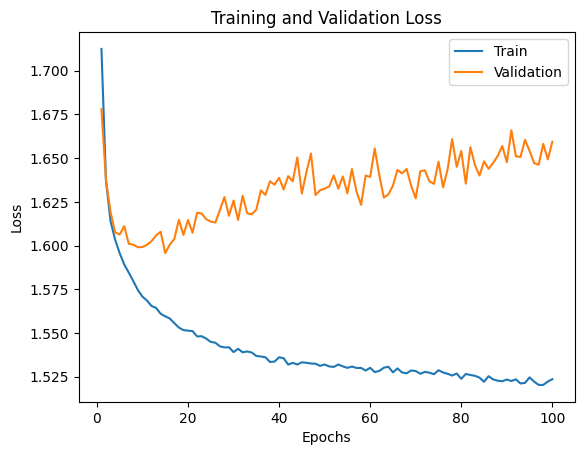

In [6]:
import matplotlib.pyplot as plt

num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    for student_id, performance_score, tgt_distbn in train_loader:
        optimizer.zero_grad()
        outputs = model(student_id, performance_score)
        loss = criterion(outputs, tgt_distbn)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for student_id, performance_score, tgt_distbn in val_loader:
            outputs = model(student_id, performance_score)
            loss = criterion(outputs, tgt_distbn)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}', end='\r')

# Plotting the training and validation losses
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

From the training progress, it appears that the model is over-fitting w.r.t the training set; however, I would imagine this has to do with the small size of the dataset. The neural network approach requires more data than simpler model-based methods or memory-based methods. Of course there are also ways to mitigate some of the over-fitting such as using dropout, larger batch size, etc.

This is also a simple mock dataset and I would imagine with a more realistic dataset, there would be less overfitting as well.

## Model Evaluation

After training, we assess the model's performance by visualizing the loss over epochs and analyzing the predicted interaction distributions for different learner profiles. This step ensures that our model's recommendations align with the unique characteristics and preferences of each learner type (which were not used during trainig).

### Visualization:

- Plotting training and validation losses to assess model convergence.
- Analyzing predicted content interaction distributions for different learner profiles, validating the model's effectiveness in capturing distinct learning preferences.

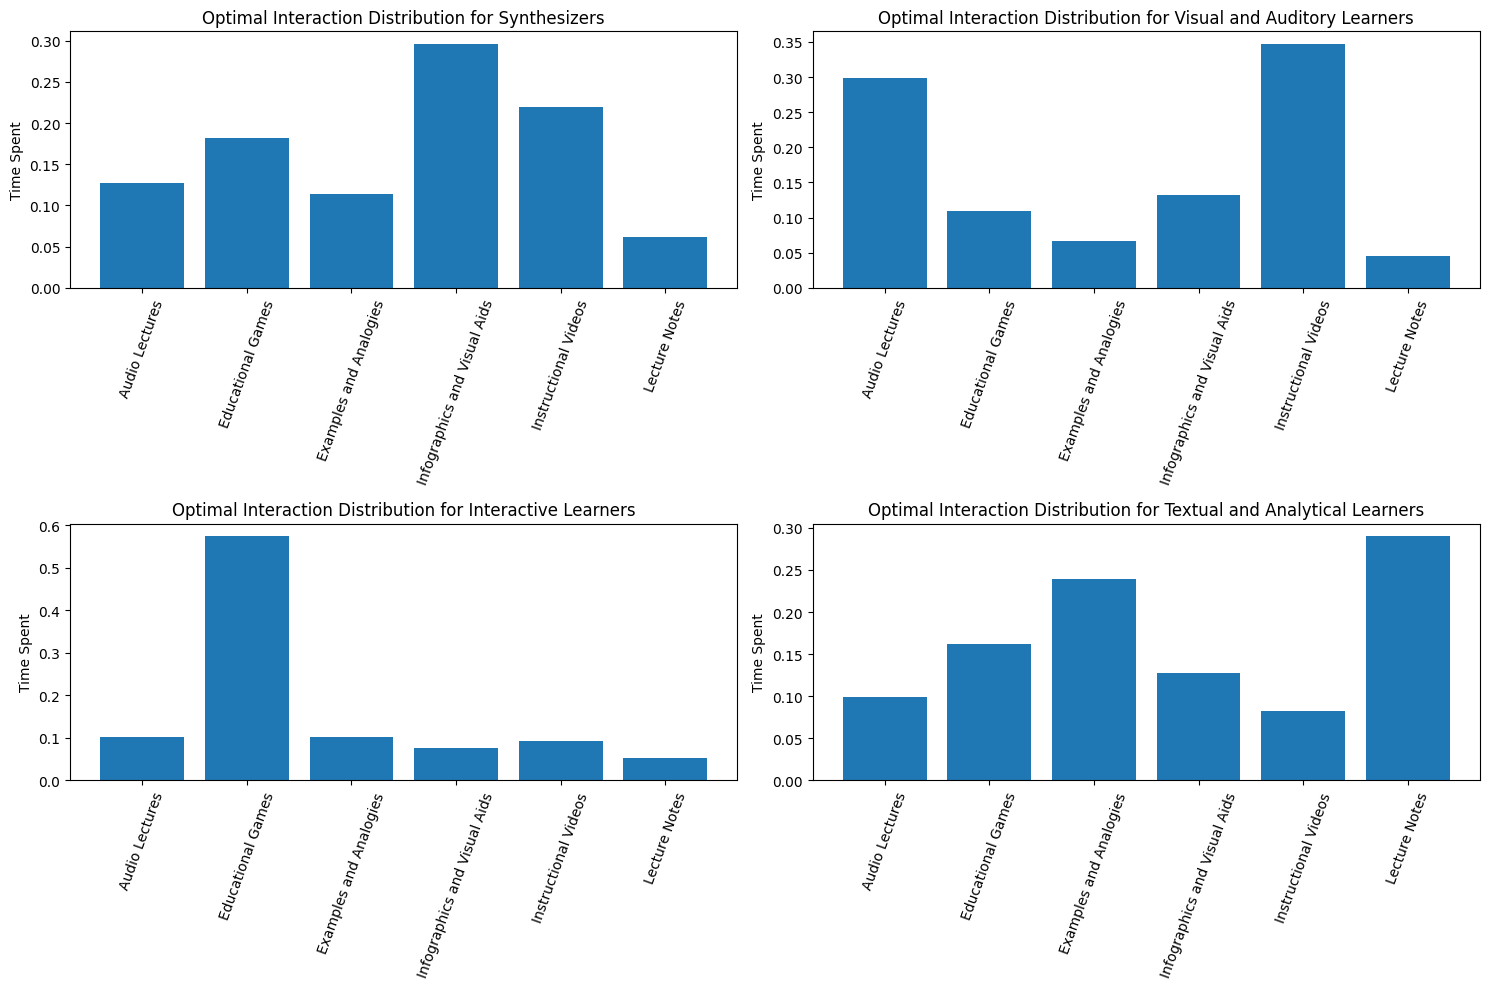

In [7]:
import matplotlib.pyplot as plt

# Find one StudentID for each LearnerProfile
unique_profiles = df['LearnerProfile'].unique()
student_ids_for_profiles = {}

# Number of profiles
num_profiles = len(unique_profiles)
cols = 2  # Number of columns in grid
rows = num_profiles // cols + (num_profiles % cols > 0)  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten to simplify indexing

for profile in unique_profiles:
    student_ids_for_profiles[profile] = df[df['LearnerProfile'] == profile]['StudentID'].iloc[0]

# Predict optimal distribution and plot histograms
for i, (profile, student_id) in enumerate(student_ids_for_profiles.items()):
    # Prepare input for model
    performance_score = torch.tensor([1.0], dtype=torch.float32)  # Assuming best performance score
    student_tensor = torch.tensor([student_id], dtype=torch.int) - 1 # Starting indexing at 0

    # Predict the distribution
    with torch.no_grad():
        predicted_distribution = model(student_tensor, performance_score, out_distbn=True)

     # Plotting in subplot
    axes[i].bar(range(len(predicted_distribution[0])), predicted_distribution[0])
    axes[i].set_title(f'Optimal Interaction Distribution for {profile}')
    axes[i].set_ylabel('Time Spent')
    axes[i].set_xticks(range(len(keys)))
    axes[i].set_xticklabels(keys, rotation=70)

# Adjust layout
plt.tight_layout()
plt.show()

## Conclusion and Future Directions

Our model offers a foundational approach to recommending educational content. However, it currently lacks the capability to handle new student IDs not present in the training phase. 

To address this, there are a few strategies you could consider:

1. **Cold Start Strategy**: Implement a cold start strategy for new students. This often involves using a generalized model or heuristic until enough data is collected about the new student. For instance, initially, you might recommend a balanced content type distribution until the model learns more about the student's preferences and performance.

2. **Metadata-Based Embeddings**: If you have additional metadata about students (like their learning preferences, prior educational background, or demographic information), you could use this data to generate initial embeddings for new students. This approach can provide a starting point that's more personalized than a generic model.

3. **Similarity-Based Assignment**: Another approach could be to find students in the training data who are similar to the new student based on available features. You can use their embedding as a proxy for the new student until more personalized data is collected.

4. **Hybrid Approach**: Combine content-based and collaborative filtering approaches. This could involve using both the content being interacted with and the user's characteristics to predict the interaction duration.

5. **Online Learning**: Continuously update the model with new data. As the model encounters new StudentIDs and their interactions, it can adjust and fine-tune the embeddings accordingly.

Each of these strategies has its strengths and limitations, and the choice might depend on the specific constraints and objectives of your recommender system.

## Visualize the distribution of StudentID Embedding

For instance, it could be possible to look at the student embeddings to see if they cluster depending on the different learning styles.

The beginnings of such an exploration are shown below:

In [60]:
# Prepare input for model
student_tensor = torch.arange(df['StudentID'].nunique())
# Predict the embeddings
with torch.no_grad():
    student_embeddings = model.student_embedding(student_tensor)

In [61]:
import umap

reducer = umap.UMAP()
reducer.fit(student_embeddings)
umap_embedding = reducer.transform(student_embeddings)

student_profiles = []
for student_id in student_tensor:
    student_id = int(student_id) + 1
    student_profiles.append(df[df['StudentID'] == student_id]['LearnerProfile'].iloc[0])
student_profiles = np.array(student_profiles)

student_profiles_nums = np.zeros((len(student_profiles),))
profiles = {}
for i, prof in enumerate(np.unique(student_profiles)):
    profiles[prof] = i
    student_profiles_nums[student_profiles==prof] = i

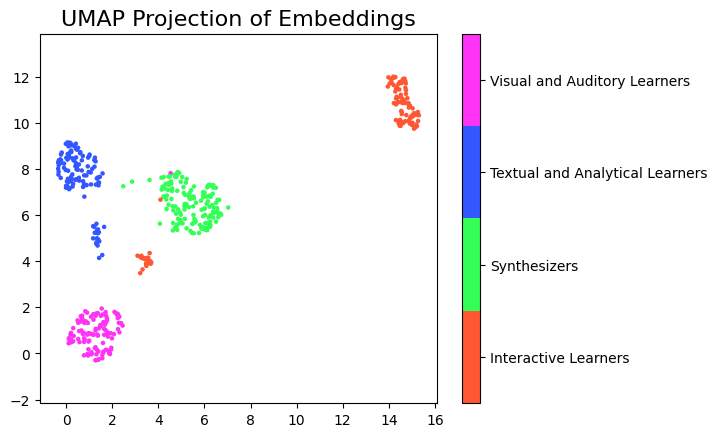

In [62]:
from matplotlib.colors import ListedColormap
# Define four distinct colors
colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33F6']  # Example colors: red, green, blue, pink
# Create a custom colormap
custom_cmap = ListedColormap(colors)

pts = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=student_profiles_nums, cmap=custom_cmap, s=5, vmin=0, vmax=len(profiles)-1)

plt.gca().set_aspect('equal', 'datalim')
# Colorbar
cbar = plt.colorbar(pts, ticks=np.linspace(0, len(profiles)-1, 2*len(profiles)+1)[1::2])
cbar.ax.set_yticklabels(profiles.keys())

#plt.colorbar(pts)
plt.title('UMAP Projection of Embeddings', fontsize=16)
plt.show()